In [ ]:
%load_ext jupyter_black

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("test_data_scientist/train.csv.gz", compression="gzip")
df_test = pd.read_csv("test_data_scientist/test.csv.gz", compression="gzip")
df_bu_feat = pd.read_csv("test_data_scientist/bu_feat.csv.gz", compression="gzip")

print(df_train.shape)
print(df_train.head())


print(df_test.shape)
print(df_test.head())

print(df_bu_feat.shape)
print(df_bu_feat.head())

(277719, 4)
       day_id  but_num_business_unit  dpt_num_department     turnover
0  2017-09-30                     64                 127   580.308443
1  2017-09-30                    119                 127  1512.995918
2  2017-09-30                      4                  88   668.593556
3  2017-09-30                    425                 127     0.000000
4  2017-09-30                    513                  73     0.000000
(10136, 3)
       day_id  but_num_business_unit  dpt_num_department
0  2017-11-25                     95                  73
1  2017-11-25                      4                 117
2  2017-11-25                    113                 127
3  2017-11-25                     93                 117
4  2017-11-25                     66                 127
(326, 6)
   but_num_business_unit  but_postcode  but_latitude  but_longitude  \
0                   1609         80100     50.096306       1.867220   
1                   1995         95700     48.991087       2.520

In [3]:
df_test

,day_id,but_num_business_unit,dpt_num_department
0,2017-11-25,95,73
1,2017-11-25,4,117
2,2017-11-25,113,127
3,2017-11-25,93,117
4,2017-11-25,66,127
...,...,...,...
10131,2017-10-07,61,88
10132,2017-10-07,641,117
10133,2017-10-07,724,117
10134,2017-10-07,1302,117


In [25]:
df_merged_train = df_train.merge(df_bu_feat, on="but_num_business_unit", how="left")

df_merged_test = df_test.merge(df_bu_feat, on="but_num_business_unit", how="left")


df_merged_test

,day_id,but_num_business_unit,dpt_num_department,turnover,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
0,2017-11-25,95,73,40.441509,80000,49.869382,2.280452,69,4
1,2017-11-25,4,117,142.562256,6600,43.600994,7.078160,55,10
2,2017-11-25,113,127,64.743538,84014,43.919562,4.867583,115,10
3,2017-11-25,93,117,71.607681,13008,43.239744,5.396694,71,10
4,2017-11-25,66,127,59.323837,34500,43.347835,3.255024,6,10
...,...,...,...,...,...,...,...,...,...
10131,2017-10-07,61,88,503.282990,60740,49.238738,2.468513,69,4
10132,2017-10-07,641,117,526.825195,17810,45.749749,-0.675981,70,10
10133,2017-10-07,724,117,893.663086,38150,45.327709,4.804922,52,4
10134,2017-10-07,1302,117,884.007080,74950,46.069548,6.549448,51,4


In [ ]:
def add_seasonal_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add seasonal time-based features to the merged store-department DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing 'day_id', 'but_num_business_unit', and 'dpt_num_department'.

    Returns
    -------
    pd.DataFrame
        DataFrame with added features for week-of-year and day-of-year seasonality.
    """
    df = df.copy()

    df["day_id"] = pd.to_datetime(df["day_id"])

    df = df.sort_values(
        ["but_num_business_unit", "dpt_num_department", "day_id"]
    ).reset_index(drop=True)

    df["week_of_year"] = df["day_id"].dt.isocalendar().week.astype(int)
    df["sin_week"] = np.sin(2 * np.pi * df["week_of_year"] / 52)
    df["cos_week"] = np.cos(2 * np.pi * df["week_of_year"] / 52)

    df["day_of_year"] = df["day_id"].dt.dayofyear
    df["sin_day"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
    df["cos_day"] = np.cos(2 * np.pi * df["day_of_year"] / 365)

    return df


df_merged_train = add_seasonal_features(df_merged_train)
df_merged_test = add_seasonal_features(df_merged_test)

In [ ]:
lags = [1, 3, 5, 11, 25]


def create_lags_and_rollings_time_fill(df, lags=lags, windows=[3, 11, 25], fill_lag=52):
    """
    Create lag and rolling features and fill missing weeks with the same week last year.

    Parameters
    ----------
    df : pd.DataFrame
        Subset of data for a single store-department
        Must have 'day_id' (datetime) and 'turnover' columns.
    lags : list of int
        Number of weeks back for lag features.
    windows : list of int
        Window sizes for rolling mean/std (in weeks).
    fill_lag : int
        Lag in weeks to fill missing values (e.g., 52 for same week last year)

    Returns
    -------
    pd.DataFrame
        DataFrame with lag, rolling, and filled features.
    """
    df["day_id"] = pd.to_datetime(df["day_id"], errors="coerce")
    df = df.sort_values("day_id").set_index("day_id")
    df = df.asfreq("W-SAT")
    df["turnover"] = df["turnover"].fillna(df["turnover"].shift(fill_lag))

    for lag in lags:
        df[f"lag_{lag}"] = df["turnover"].shift(lag)

    for window in windows:
        df[f"rolling_mean_{window}"] = (
            df["turnover"].shift(1).rolling(window=window).mean()
        )
        df[f"rolling_std_{window}"] = (
            df["turnover"].shift(1).rolling(window=window).std()
        )

    return df.reset_index()


def merge_train_test(df_train, df_test):
    """
    Concatenate train and test datasets with an indicator column.

    Parameters
    ----------
    df_train : pd.DataFrame
        Training dataset
    df_test : pd.DataFrame
        Test dataset

    Returns
    -------
    pd.DataFrame
        Concatenated dataset with 'train' indicator (1 for train, 0 for test)
    """
    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()

    df_train_copy["train"] = 1
    df_test_copy["train"] = 0


    df_full = pd.concat([df_train_copy, df_test_copy], axis=0, ignore_index=True)
    return df_full


df_full = merge_train_test(df_merged_train, df_merged_test)

df_full = (
    df_full.groupby(["but_num_business_unit", "dpt_num_department"])
    .apply(create_lags_and_rollings_time_fill)
    .reset_index(drop=True)
)


df = df_full.sort_values(by="day_id")

/tmp/ipykernel_131593/2546050484.py:75: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(create_lags_and_rollings_time_fill)


In [7]:
df_filtered = df[(df["but_num_business_unit"] == 1) & (df["dpt_num_department"] == 73)]
df_filtered.loc[254]

day_id                   2017-11-11 00:00:00
but_num_business_unit                      1
dpt_num_department                        73
turnover                           40.249345
but_postcode                           59320
but_latitude                        50.62806
but_longitude                       2.957377
but_region_idr_region                     65
zod_idr_zone_dgr                           4
week_of_year                              45
sin_week                           -0.748511
cos_week                            0.663123
day_of_year                              315
sin_day                            -0.758306
cos_day                             0.651899
train                                      0
lag_1                              27.221974
lag_3                              62.445513
lag_5                             131.982449
lag_11                             23.078028
lag_25                             41.740085
rolling_mean_3                     47.951131
rolling_st

In [ ]:
df = df.drop(columns=["day_id"])

In [9]:
df_processed_train = df_full[df_full["train"] == 1].copy()
df_processed_test = df_full[df_full["train"] == 0].copy()

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (277719, 4)
Test shape: (10136, 3)


In [10]:
feature_cols = [col for col in df.columns if col not in ["turnover", "train"]]
X = df_processed_train[feature_cols]
X_test = df_processed_test[feature_cols]
y = df_processed_train["turnover"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)

In [11]:
X

,but_num_business_unit,dpt_num_department,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr,week_of_year,sin_week,cos_week,...,lag_3,lag_5,lag_11,lag_25,rolling_mean_3,rolling_std_3,rolling_mean_11,rolling_std_11,rolling_mean_25,rolling_std_25
0,1,73,59320,50.628060,2.957377,65,4,52,6.432491e-16,1.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,73,59320,50.628060,2.957377,65,4,1,1.205367e-01,9.927089e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,73,59320,50.628060,2.957377,65,4,2,2.393157e-01,9.709418e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,73,59320,50.628060,2.957377,65,4,3,3.546049e-01,9.350162e-01,...,15.552508,NaN,NaN,NaN,13.210098,4.437292,NaN,NaN,NaN,NaN
4,1,73,59320,50.628060,2.957377,65,4,4,4.647232e-01,8.854560e-01,...,8.092452,NaN,NaN,NaN,13.706588,4.890604,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287842,1887,127,59240,51.050275,2.393182,65,4,35,-8.854560e-01,-4.647232e-01,...,18.527632,10.855613,8.252935,NaN,12.987753,4.815077,9.169000,5.500898,NaN,NaN
287843,1887,127,59240,51.050275,2.393182,65,4,36,-9.350162e-01,-3.546049e-01,...,9.808821,12.188730,0.412806,NaN,9.213182,1.787492,9.073635,5.527396,NaN,NaN
287844,1887,127,59240,51.050275,2.393182,65,4,37,-9.709418e-01,-2.393157e-01,...,10.626806,18.527632,0.000000,NaN,5.943575,5.424353,9.036107,5.593090,NaN,NaN
287845,1887,127,59240,51.050275,2.393182,65,4,38,-9.927089e-01,-1.205367e-01,...,7.203919,9.808821,7.296078,NaN,2.401306,4.159185,9.036107,5.593090,NaN,NaN


In [12]:
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)

[0]	validation_0-rmse:597.47379
[50]	validation_0-rmse:377.51311
[100]	validation_0-rmse:253.19482
[150]	validation_0-rmse:187.90243
[200]	validation_0-rmse:156.48604
[250]	validation_0-rmse:142.02398
[300]	validation_0-rmse:135.28497
[350]	validation_0-rmse:131.63792
[400]	validation_0-rmse:130.10151
[450]	validation_0-rmse:129.80604
[497]	validation_0-rmse:129.76220


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


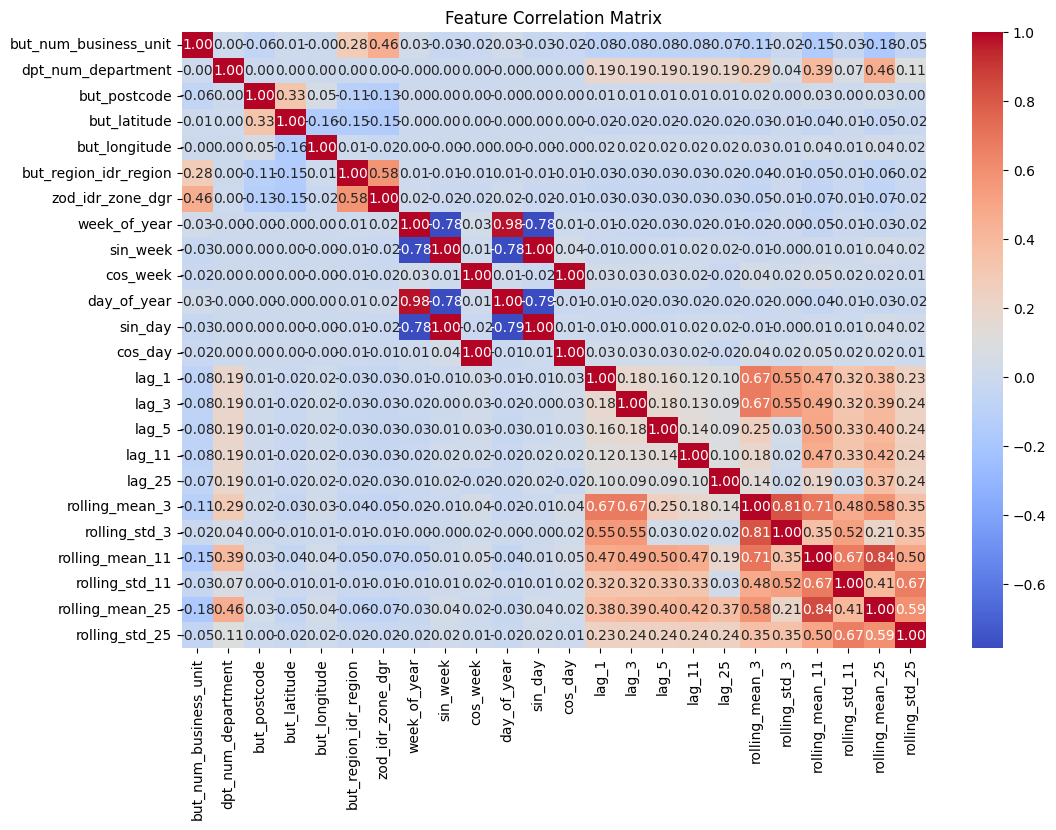

In [ ]:
corr_matrix = df[feature_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 53.51
RMSE: 129.24
R²: 0.94


# WRONG!!

I was using the norma train test split. Temporal split is needed on this case

In [ ]:
split_idx = int(len(df) * 0.8)

X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_val)}")


model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
)


model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10)

Training samples: 230284, Testing samples: 47435
[0]	validation_0-rmse:640.86284
[10]	validation_0-rmse:582.97320
[20]	validation_0-rmse:531.10298
[30]	validation_0-rmse:484.45852
[40]	validation_0-rmse:442.42604
[50]	validation_0-rmse:405.15580
[60]	validation_0-rmse:371.75655
[70]	validation_0-rmse:342.08677
[80]	validation_0-rmse:315.79255
[90]	validation_0-rmse:293.54244
[100]	validation_0-rmse:275.33971
[110]	validation_0-rmse:257.34391
[120]	validation_0-rmse:241.61834
[130]	validation_0-rmse:228.49281
[140]	validation_0-rmse:218.15187
[150]	validation_0-rmse:207.86750
[160]	validation_0-rmse:199.03975
[170]	validation_0-rmse:191.45421
[180]	validation_0-rmse:185.05421
[190]	validation_0-rmse:179.46985
[200]	validation_0-rmse:175.03080
[210]	validation_0-rmse:170.75472
[220]	validation_0-rmse:167.16531
[230]	validation_0-rmse:164.28300
[240]	validation_0-rmse:162.36299
[250]	validation_0-rmse:160.08873
[260]	validation_0-rmse:158.53390
[270]	validation_0-rmse:156.77869
[280]	vali

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [16]:
# Predict
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 57.84
RMSE: 143.33
R²: 0.94


In [ ]:
results = pd.DataFrame(
    {
        "department": X_val["dpt_num_department"].values,
        "y_true": y_val.values,
        "y_pred": y_pred,
    }
)


def compute_metrics(group):
    mae = mean_absolute_error(group["y_true"], group["y_pred"])
    rmse = np.sqrt(mean_squared_error(group["y_true"], group["y_pred"]))
    return pd.Series({"MAE": mae, "RMSE": rmse})


metrics_by_dept = results.groupby("department").apply(compute_metrics).reset_index()

print(metrics_by_dept)

   department         MAE        RMSE
0          73   15.855184   42.520970
1          88   36.978644  106.238609
2         117   61.069102  168.480192
3         127  115.247933  199.668655


/tmp/ipykernel_131593/1467723798.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_dept = results.groupby("department").apply(compute_metrics).reset_index()


# TEST SET

In [18]:
# Predict
y_pred = model.predict(X_test)

In [19]:
y_pred

array([ 40.44151, 142.56226,  64.74354, ..., 893.6631 , 884.0071 ,
       952.77216], shape=(10136,), dtype=float32)

In [20]:
df_test["turnover"] = y_pred

In [23]:
df_test

,day_id,but_num_business_unit,dpt_num_department,turnover
0,2017-11-25,95,73,40.441509
1,2017-11-25,4,117,142.562256
2,2017-11-25,113,127,64.743538
3,2017-11-25,93,117,71.607681
4,2017-11-25,66,127,59.323837
...,...,...,...,...
10131,2017-10-07,61,88,503.282990
10132,2017-10-07,641,117,526.825195
10133,2017-10-07,724,117,893.663086
10134,2017-10-07,1302,117,884.007080


In [24]:
df_test.to_csv("test_results.csv", index=False)